In [22]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [23]:
# Se cargan las diferentes dependencias necesarias
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib as mpl

from IPython import display

In [24]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
   # sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
   # wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

(16000,)


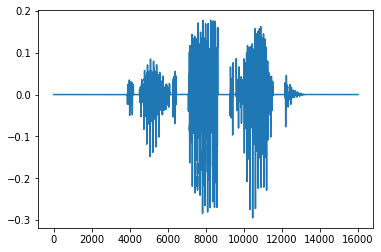

In [25]:
# Ejemplo de carga de un archivo
RutaFile="/content/gdrive/MyDrive/Colab Notebooks/Datos/Comandos/Training/Arriba1.wav"
wave = load_wav_16k_mono(RutaFile)
print(wave.shape)
plt.plot(wave)
plt.show()



In [26]:
def preprocess(wave): 
    #wav = wave[:32000]
    wav = wave[:16000]
    #zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
   # wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    return spectrogram

In [27]:
espectrograma= preprocess(wave)
print('Waveform shape:', wave.shape)
print('Spectrogram shape:', espectrograma.shape)
print('Audio playback')
display.display(display.Audio(wave, rate=16000))

Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


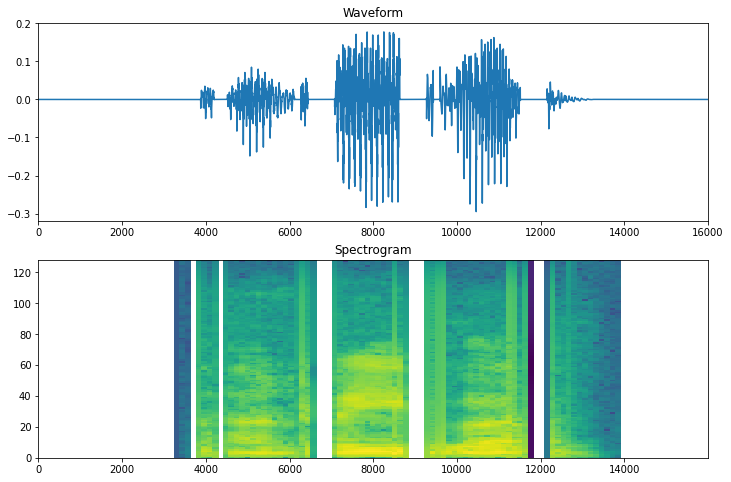

In [28]:
def plot_spectrogram(espectrograma, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(espectrograma.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(espectrograma), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(wave.shape[0])
axes[0].plot(timescale, wave.numpy())
axes[0].set_title('Waveform')
#axes[0].set_xlim([0, 32000])
axes[0].set_xlim([0, 16000])
plot_spectrogram(espectrograma.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [29]:
# Se cargan los diferentes archivos *.json que se van a usar en el proceso
# de entrenamiento
import os
directory = '/content/gdrive/MyDrive/Colab Notebooks/Datos/Comandos/Training/'
files = os.listdir(directory)
files.sort() 
cantidadFiles = len(files)
# Variable donde se almacenaron los datos leidos de los archivos *.json
#Datos=np.zeros((cantidadFiles*624,3))
Datos=np.zeros((cantidadFiles,124,129))
i = 0
for file in files:
  RutaFile=directory + file
  wave = load_wav_16k_mono(RutaFile)
  espectrograma= preprocess(wave)
  Datos[i,:,:]=espectrograma
  i+=1
print(Datos.shape)
Xtrain=tf.expand_dims(Datos, axis=3)
print(Xtrain.shape)



(15, 124, 129)
(15, 124, 129, 1)


In [30]:
YtrainIni=np.zeros((15,1))
for i in range(5):
    YtrainIni[i]=0

for i in range(5,10):
    YtrainIni[i]=1

for i in range(10,15):
    YtrainIni[i]=2

#for i in range(15,20):
#    YtrainIni[i]=3

print(YtrainIni)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]]


In [31]:
Ytrain= keras.utils.to_categorical(YtrainIni)
print(Ytrain)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 124, 129, 8)       80        
                                                                 
 conv2d_5 (Conv2D)           (None, 124, 129, 16)      1168      
                                                                 
 conv2d_6 (Conv2D)           (None, 124, 129, 32)      4640      
                                                                 
 conv2d_7 (Conv2D)           (None, 124, 129, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 65, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 257920)            0         
                                                      

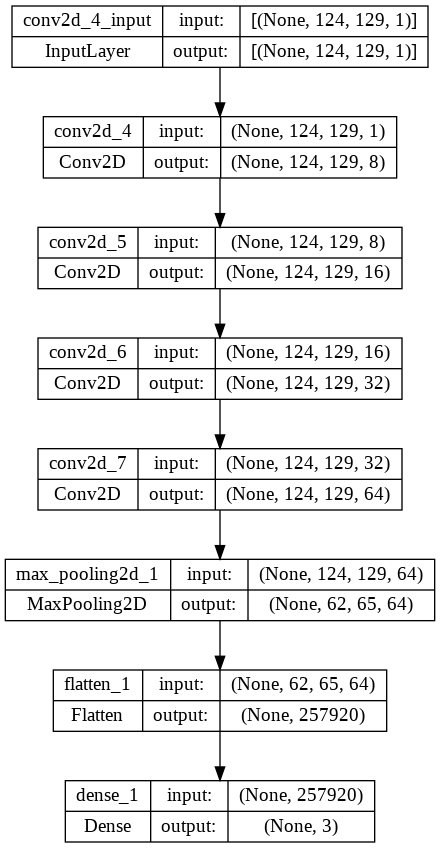

In [32]:

#Definición del modelo
modelo = keras.models.Sequential()
modelo.add(keras.layers.Conv2D(8, 3, activation="relu",padding="same", input_shape=(124,129,1)))
modelo.add(keras.layers.Conv2D(16, 3, activation="relu",padding="same"))
modelo.add(keras.layers.Conv2D(32, 3, activation="relu",padding="same"))
modelo.add(keras.layers.Conv2D(64, 3, activation="relu",padding="same"))
modelo.add(keras.layers.MaxPooling2D(pool_size=2,strides=2, padding='same'))
modelo.add(keras.layers.Flatten())
modelo.add(keras.layers.Dense(3, activation = 'softmax'))
modelo.summary()

keras.utils.plot_model(modelo, to_file='model_plot3.png', show_shapes=True, show_layer_names=True)

In [33]:
modelo.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = modelo.fit(Xtrain,Ytrain, epochs=30,batch_size=None)


Epoch 1/30
1/1 [==============================] - 2s 2s/step - loss: 1.0962 - accuracy: 0.5333
Epoch 2/30
1/1 [==============================] - 1s 1s/step - loss: 0.6006 - accuracy: 1.0000
Epoch 3/30
1/1 [==============================] - 1s 1s/step - loss: 0.2336 - accuracy: 1.0000
Epoch 4/30
1/1 [==============================] - 1s 1s/step - loss: 0.0488 - accuracy: 1.0000
Epoch 5/30
1/1 [==============================] - 1s 1s/step - loss: 0.0095 - accuracy: 1.0000
Epoch 6/30
1/1 [==============================] - 1s 1s/step - loss: 0.0019 - accuracy: 1.0000
Epoch 7/30
1/1 [==============================] - 1s 1s/step - loss: 3.1958e-04 - accuracy: 1.0000
Epoch 8/30
1/1 [==============================] - 1s 1s/step - loss: 4.5118e-05 - accuracy: 1.0000
Epoch 9/30
1/1 [==============================] - 1s 1s/step - loss: 5.7378e-06 - accuracy: 1.0000
Epoch 10/30
1/1 [==============================] - 2s 2s/step - loss: 6.9141e-07 - accuracy: 1.0000
Epoch 11/30
1/1 [================

1/1 [==============================] - 0s 459ms/step - loss: 0.0000e+00 - accuracy: 1.0000


[0.0, 1.0]

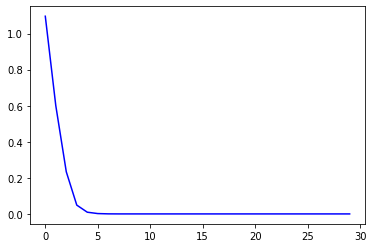

In [34]:
plt.plot(history.history["loss"],'b')
modelo.evaluate(Xtrain, Ytrain)

In [35]:
# Se cargan los diferentes archivos *.json que se van a usar en el proceso
# de testeo

import os
directory = '/content/gdrive/MyDrive/Colab Notebooks/Datos/Comandos/Testing/'
files = os.listdir(directory)
files.sort() 

cantidadFiles = len(files)

DatosVal=np.zeros((cantidadFiles,124,129))
i = 0
for file in files:
  RutaFile=directory + file
  wave = load_wav_16k_mono(RutaFile)
  espectrograma= preprocess(wave)
  DatosVal[i,:,:]=espectrograma
  i+=1
print(DatosVal.shape)
XVal=tf.expand_dims(DatosVal, axis=3)
print(XVal.shape)

(6, 124, 129)
(6, 124, 129, 1)


In [36]:
YValIni=np.zeros((6,1))
for i in range(2):
    YValIni[i]=0

for i in range(2,4):
    YValIni[i]=1

for i in range(4,6):
    YValIni[i]=2 

#for i in range(6,8):
#    YValIni[i]=3      

print(YValIni)
YVal= keras.utils.to_categorical(YValIni)

print(YVal)

[[0.]
 [0.]
 [1.]
 [1.]
 [2.]
 [2.]]
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [37]:
modelo.evaluate(XVal, YVal)

1/1 [==============================] - 0s 134ms/step - loss: 0.0000e+00 - accuracy: 1.0000


[0.0, 1.0]

1/1 [==============================] - 0s 225ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6

[[2 0 0]
 [0 2 0]
 [0 0 2]]


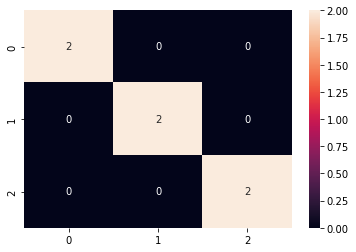

In [38]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

ypredic=modelo.predict(XVal)

y_test_class = np.argmax(YVal,axis=1) 
y_pred_class = np.argmax(ypredic,axis=1) 

#Accuracy of the predicted values
print(classification_report(y_test_class, y_pred_class)) # Precision , Recall, F1-Score & Support
cm = confusion_matrix(y_test_class, y_pred_class)
print(cm)
# visualize the confusion matrix in a heat map
df_cm = pd.DataFrame(cm)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")